This notebook provides a comprehensive guide for building and training a neural network using the methodology we developed during the competition. In addition, the final section of the notebook demonstrates how to perform inference and generate a valid log for submission.

# Download dataset

Download the dataset in TFRecord file format. Alternatively, create your own train/test files exploiting the notebook `convert_dataset_to_TFRecords.ipynb` in the folder `convert_to_TFRecord`.

In [ ]:
%cd
%cd hyperspectral-cnn-soil-estimation/dataset

#Challenge train set: will be used for training and validation
!gdown https://drive.google.com/uc?id=1wD3vKqKEFh6OfrfLNtOENF-lbe4auQDb

#Challenge test set: no labels are provided, will be used for making inference
!gdown https://drive.google.com/uc?id=1XPaSRHsGHGkLieZnR6cU8-Bwg6_1kCTj

%cd

# Define dataset paths

Navigate to the working directory.

In [1]:
%cd
%cd hyperspectral-cnn-soil-estimation

/home/microsat
/home/microsat/hyperspectral-cnn-soil-estimation


In [2]:
train_set_path = 'dataset/train_tfrecords0.record'
test_set_path = 'dataset/test_tfrecords0.record'

# Import required libraries and functions

Import libraries and set random seeds.

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import os, zipfile, logging
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import random as rn
rn.seed(2)
import numpy as np
np.random.seed(3)
SEED = 7231
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

#Disable GPU
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

#Enable full deterministic operations
#This options slows down the training process remarkably but it allows to get 
#deterministic results through different runs of the code
#note that results might differ on different hardware (cpu vs gpu) and on different computers
os.environ['TF_DETERMINISTIC_OPS'] = '1'

import tensorflow as tf
from dataset_processing import *
from efficientnet_lite import EfficientNetLiteB0mod
import tensorflow.keras.layers as layers

tf.random.set_seed(1)

AUTO = tf.data.AUTOTUNE 

# Define training hyperparameters

In [4]:
noise_std = 0.05
epochs = 300
batch_size = 32
target_image_size = 32
start_lr = 0.005 
network_name = 'cnn_final'

label_normalization_mode = 0 # 0 for minmax normalization, everything else for standard normalization

###########################################################
max_reflectance = 6315
test_set_len = 1153
max_labels = [325., 625., 400., 14.]
std_labels = [29.496254, 61.874084, 39.860474, 0.2602235]
mean_labels = [70.30264, 227.98851, 159.28125, 6.782706]
train_set_len = len(list(load_tf_records(train_set_path)))

num_train_images = (train_set_len//batch_size)*batch_size

Learning rate scheduling.

Learning rate per epoch:


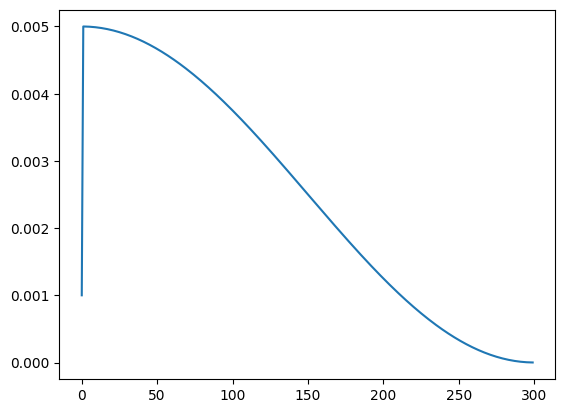

In [5]:
alpha = 0.0001
decay_steps = epochs

def lr_scheduler(epoch, start_lr):
    if epoch < 1:
      lr = (start_lr-0.001)/1*epoch+0.001
    else:
      cosine_decay = 0.5 * (1 + tf.cos(np.pi * epoch / (decay_steps)))
      decayed = (1 - alpha) * cosine_decay + alpha
      lr = start_lr * decayed
    return lr

lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: lr_scheduler(epoch, start_lr), verbose=0)

#Plot learning rate

x_range = np.arange(epochs)
y = [lr_scheduler(x, start_lr) for x in x_range]
plt.plot(x_range, y)
print('Learning rate per epoch:')

# Define saving paths

In [6]:
base_path = 'networks/'

saved_model_filepath = base_path + network_name 
h5_filepath = saved_model_filepath + '/'+network_name+'.h5'
submission_name = 'submission_files/sumbission_' + network_name + '.csv'
submission_zip = 'submission_files/sumbission_' + network_name + '.zip'

# Build the neural network

Define a custom metric reflecting the competition scoring.

In [7]:
def custom_metric(y_true, y_pred):
    y_true = tf.cond(tf.math.equal(label_normalization_mode,0), 
                     lambda: tf.multiply(y_true, max_labels),
                     lambda: tf.multiply(y_true, std_labels)+mean_labels)
    y_pred = tf.cond(tf.math.equal(label_normalization_mode,0), 
                     lambda: tf.multiply(y_pred, max_labels),
                     lambda: tf.multiply(y_pred, std_labels)+mean_labels)
    
    mse = tf.reduce_mean((y_true-y_pred)**2, axis=0)
    mse_baseline = [870.02899169921875, 3828.40234375, 1588.857421875, 0.0677162706851959228515625]
    score = tf.reduce_mean(mse/mse_baseline)

    return score

In [8]:
backbone = EfficientNetLiteB0mod(input_shape=(target_image_size, target_image_size, 150),
                                   width_coefficient=0.5,
                                   depth_coefficient=0.5,
                                   dropout_rate=0.1
                                   )

model = tf.keras.Sequential([backbone,  
                                layers.Flatten(),
                                layers.Dense(4, kernel_initializer=tf.keras.initializers.GlorotUniform(seed=1509))])


model.compile(
    optimizer=tf.keras.optimizers.Adam(clipnorm=1.),
    loss='mse',
    metrics=[custom_metric],
  )

#Initialize the model with the same weights we employed during the competition
model.load_weights('efficientnet_lite/initialization_weigths.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetlite0mod (Funct  (None, 1, 1, 1280)       728896    
 ional)                                                          
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 4)                 5124      
                                                                 
Total params: 734,020
Trainable params: 719,780
Non-trainable params: 14,240
_________________________________________________________________


# Dataset preprocessing

In [9]:
steps_per_epoch = num_train_images//batch_size

ds = load_tf_records(train_set_path).map(decode_dataset_train_val, num_parallel_calls=AUTO,deterministic=True)
ds = ds.shuffle(train_set_len, seed=1860)

#Train
train_data = ds.take(num_train_images)
train_data = train_data.map(lambda patch, label, height, width: normalize_train_val(patch, label, height, width, max_reflectance, max_labels, mean_labels, std_labels, label_normalization_mode), num_parallel_calls=AUTO,deterministic=True).cache()    #normalize train dataset
train_data = train_data.shuffle(num_train_images, seed=1866)    #shuffle train dataset
train_data = train_data.map(lambda patch, label, height, width: augment_train(patch, label, height, width,target_image_size,noise_std), num_parallel_calls=AUTO,deterministic=True)    
train_data = train_data.batch(batch_size=batch_size, drop_remainder=True)    #batch train dataset
train_data = train_data.prefetch(AUTO)    #prefetch train dataset

#Validation
val_data_raw = ds.skip(num_train_images).cache()    #create a small validation dataset from the last elements of the train dataset that are discarded during batching
val_data = val_data_raw.map(lambda patch, label, height, width: normalize_train_val(patch, label, height, width, max_reflectance, max_labels, mean_labels, std_labels, label_normalization_mode), num_parallel_calls=AUTO).cache()    #normalize validation dataset 
val_data = val_data.map(lambda patch, label, height, width: preprocess_val(patch, label, height, width,target_image_size), num_parallel_calls=AUTO)    #pad validation dataset
val_data = val_data.repeat()
val_data = val_data.batch(batch_size=batch_size, drop_remainder=True)    #batch validation dataset
val_data = val_data.prefetch(AUTO)    #prefetch validation dataset

Display few samples from train dataset.

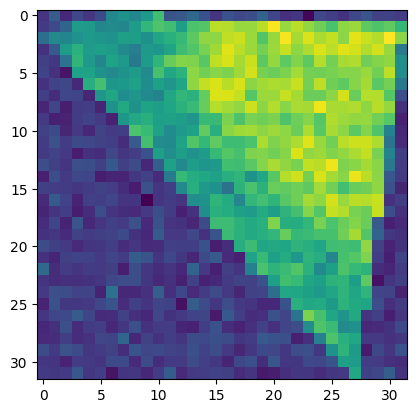

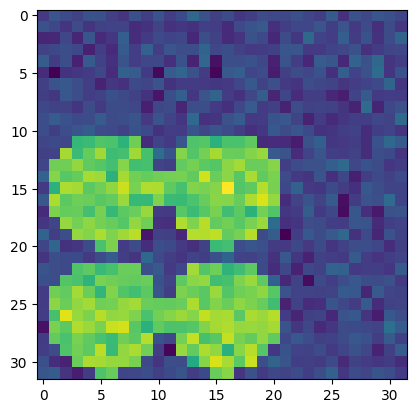

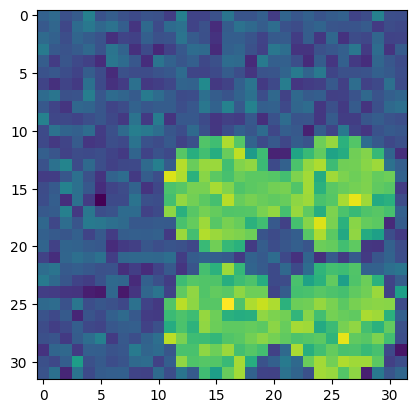

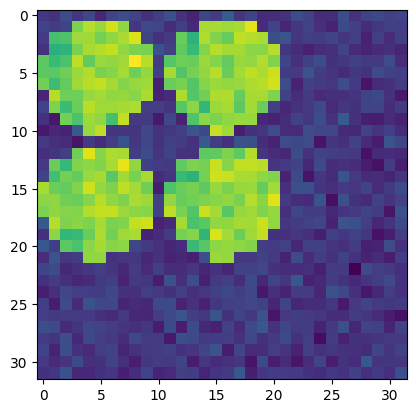

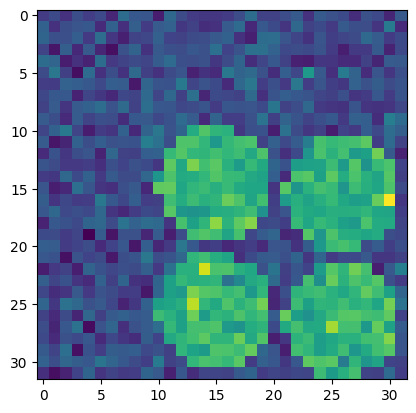

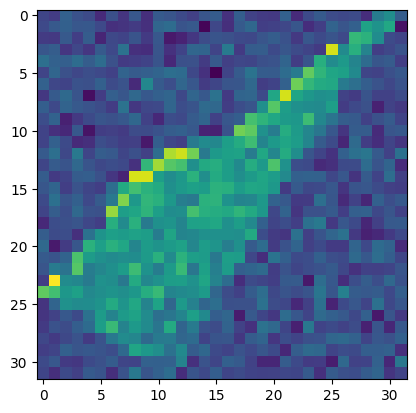

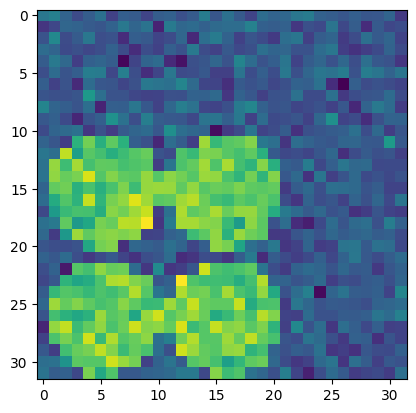

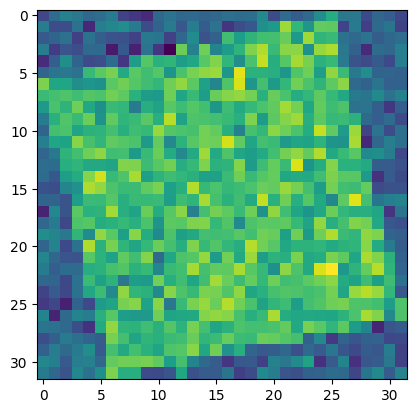

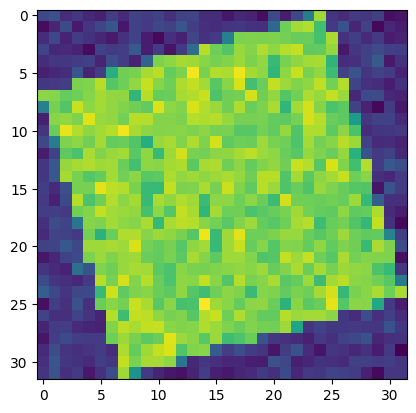

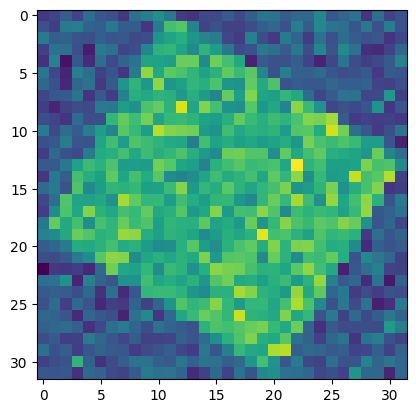

In [10]:
for image, label in train_data.unbatch().take(10):
    plt.imshow(image[:,:,149])
    plt.show()    

# Train neural network

In [11]:
History = model.fit(train_data,
                    epochs=epochs,
                    callbacks=[lr_callback],
                    validation_data=val_data,
                    validation_steps=1,
                    verbose=1)

#Export trained model
model.save(saved_model_filepath)
model.save(h5_filepath)

Epoch 1/300
54/54 [==============================] - 14s 163ms/step - loss: 0.3752 - custom_metric: 290.2100 - val_loss: 0.0939 - val_custom_metric: 97.7853 - lr: 0.0010
Epoch 2/300
54/54 [==============================] - 7s 121ms/step - loss: 0.2181 - custom_metric: 148.3953 - val_loss: 0.0455 - val_custom_metric: 5.2579 - lr: 0.0050
Epoch 3/300
54/54 [==============================] - 6s 114ms/step - loss: 0.0392 - custom_metric: 27.7009 - val_loss: 0.0096 - val_custom_metric: 2.5025 - lr: 0.0050
Epoch 4/300
54/54 [==============================] - 6s 117ms/step - loss: 0.0400 - custom_metric: 22.6821 - val_loss: 0.0195 - val_custom_metric: 5.0404 - lr: 0.0050
Epoch 5/300
54/54 [==============================] - 6s 114ms/step - loss: 0.0358 - custom_metric: 25.1825 - val_loss: 0.0066 - val_custom_metric: 1.1639 - lr: 0.0050
Epoch 6/300
54/54 [==============================] - 6s 118ms/step - loss: 0.0348 - custom_metric: 20.5259 - val_loss: 0.0106 - val_custom_metric: 8.6398 - lr: 0

Epoch 50/300
54/54 [==============================] - 6s 115ms/step - loss: 0.0071 - custom_metric: 1.1518 - val_loss: 0.0119 - val_custom_metric: 1.5348 - lr: 0.0047
Epoch 51/300
54/54 [==============================] - 6s 114ms/step - loss: 0.0073 - custom_metric: 1.2738 - val_loss: 0.0101 - val_custom_metric: 1.5155 - lr: 0.0047
Epoch 52/300
54/54 [==============================] - 6s 114ms/step - loss: 0.0071 - custom_metric: 1.1444 - val_loss: 0.0107 - val_custom_metric: 1.3891 - lr: 0.0047
Epoch 53/300
54/54 [==============================] - 6s 114ms/step - loss: 0.0072 - custom_metric: 1.1631 - val_loss: 0.0120 - val_custom_metric: 1.5469 - lr: 0.0046
Epoch 54/300
54/54 [==============================] - 6s 114ms/step - loss: 0.0072 - custom_metric: 1.2391 - val_loss: 0.0112 - val_custom_metric: 1.4080 - lr: 0.0046
Epoch 55/300
54/54 [==============================] - 6s 116ms/step - loss: 0.0071 - custom_metric: 1.1457 - val_loss: 0.0100 - val_custom_metric: 1.2580 - lr: 0.004

54/54 [==============================] - 6s 115ms/step - loss: 0.0064 - custom_metric: 0.9111 - val_loss: 0.0108 - val_custom_metric: 1.4580 - lr: 0.0038
Epoch 100/300
54/54 [==============================] - 6s 118ms/step - loss: 0.0063 - custom_metric: 0.9080 - val_loss: 0.0105 - val_custom_metric: 1.4408 - lr: 0.0038
Epoch 101/300
54/54 [==============================] - 6s 116ms/step - loss: 0.0064 - custom_metric: 0.9119 - val_loss: 0.0105 - val_custom_metric: 1.4136 - lr: 0.0038
Epoch 102/300
54/54 [==============================] - 6s 115ms/step - loss: 0.0065 - custom_metric: 0.9300 - val_loss: 0.0106 - val_custom_metric: 1.3930 - lr: 0.0037
Epoch 103/300
54/54 [==============================] - 6s 115ms/step - loss: 0.0064 - custom_metric: 0.9073 - val_loss: 0.0106 - val_custom_metric: 1.4745 - lr: 0.0037
Epoch 104/300
54/54 [==============================] - 6s 114ms/step - loss: 0.0064 - custom_metric: 0.9109 - val_loss: 0.0109 - val_custom_metric: 1.4632 - lr: 0.0037
Epoch 

Epoch 148/300
54/54 [==============================] - 6s 114ms/step - loss: 0.0061 - custom_metric: 0.8850 - val_loss: 0.0098 - val_custom_metric: 1.2230 - lr: 0.0026
Epoch 149/300
54/54 [==============================] - 6s 114ms/step - loss: 0.0061 - custom_metric: 0.8777 - val_loss: 0.0100 - val_custom_metric: 1.2972 - lr: 0.0026
Epoch 150/300
54/54 [==============================] - 6s 113ms/step - loss: 0.0062 - custom_metric: 0.8875 - val_loss: 0.0101 - val_custom_metric: 1.3645 - lr: 0.0025
Epoch 151/300
54/54 [==============================] - 6s 114ms/step - loss: 0.0062 - custom_metric: 0.8914 - val_loss: 0.0097 - val_custom_metric: 1.2683 - lr: 0.0025
Epoch 152/300
54/54 [==============================] - 6s 113ms/step - loss: 0.0062 - custom_metric: 0.8973 - val_loss: 0.0102 - val_custom_metric: 1.3802 - lr: 0.0025
Epoch 153/300
54/54 [==============================] - 6s 114ms/step - loss: 0.0061 - custom_metric: 0.8802 - val_loss: 0.0103 - val_custom_metric: 1.3633 - lr:

Epoch 197/300
54/54 [==============================] - 6s 118ms/step - loss: 0.0054 - custom_metric: 0.7979 - val_loss: 0.0087 - val_custom_metric: 1.1431 - lr: 0.0013
Epoch 198/300
54/54 [==============================] - 6s 117ms/step - loss: 0.0055 - custom_metric: 0.8111 - val_loss: 0.0074 - val_custom_metric: 0.9205 - lr: 0.0013
Epoch 199/300
54/54 [==============================] - 6s 116ms/step - loss: 0.0055 - custom_metric: 0.8106 - val_loss: 0.0078 - val_custom_metric: 0.9303 - lr: 0.0013
Epoch 200/300
54/54 [==============================] - 6s 116ms/step - loss: 0.0054 - custom_metric: 0.7931 - val_loss: 0.0085 - val_custom_metric: 1.1663 - lr: 0.0013
Epoch 201/300
54/54 [==============================] - 6s 120ms/step - loss: 0.0055 - custom_metric: 0.8064 - val_loss: 0.0085 - val_custom_metric: 1.1330 - lr: 0.0013
Epoch 202/300
54/54 [==============================] - 6s 116ms/step - loss: 0.0055 - custom_metric: 0.8022 - val_loss: 0.0087 - val_custom_metric: 1.1571 - lr:

54/54 [==============================] - 6s 114ms/step - loss: 0.0048 - custom_metric: 0.7159 - val_loss: 0.0079 - val_custom_metric: 1.0462 - lr: 4.1816e-04
Epoch 246/300
54/54 [==============================] - 6s 113ms/step - loss: 0.0048 - custom_metric: 0.7176 - val_loss: 0.0079 - val_custom_metric: 1.0452 - lr: 4.0378e-04
Epoch 247/300
54/54 [==============================] - 6s 113ms/step - loss: 0.0048 - custom_metric: 0.7208 - val_loss: 0.0079 - val_custom_metric: 1.0569 - lr: 3.8964e-04
Epoch 248/300
54/54 [==============================] - 6s 113ms/step - loss: 0.0048 - custom_metric: 0.7148 - val_loss: 0.0079 - val_custom_metric: 1.0553 - lr: 3.7573e-04
Epoch 249/300
54/54 [==============================] - 6s 113ms/step - loss: 0.0048 - custom_metric: 0.7137 - val_loss: 0.0076 - val_custom_metric: 1.0145 - lr: 3.6205e-04
Epoch 250/300
54/54 [==============================] - 6s 113ms/step - loss: 0.0047 - custom_metric: 0.7056 - val_loss: 0.0077 - val_custom_metric: 1.0490

Epoch 293/300
54/54 [==============================] - 6s 114ms/step - loss: 0.0046 - custom_metric: 0.6892 - val_loss: 0.0071 - val_custom_metric: 0.9060 - lr: 9.2670e-06
Epoch 294/300
54/54 [==============================] - 6s 113ms/step - loss: 0.0046 - custom_metric: 0.6824 - val_loss: 0.0071 - val_custom_metric: 0.9059 - lr: 7.2132e-06
Epoch 295/300
54/54 [==============================] - 6s 114ms/step - loss: 0.0046 - custom_metric: 0.6874 - val_loss: 0.0071 - val_custom_metric: 0.9117 - lr: 5.4327e-06
Epoch 296/300
54/54 [==============================] - 6s 113ms/step - loss: 0.0046 - custom_metric: 0.6871 - val_loss: 0.0071 - val_custom_metric: 0.9106 - lr: 3.9259e-06
Epoch 297/300
54/54 [==============================] - 6s 116ms/step - loss: 0.0045 - custom_metric: 0.6791 - val_loss: 0.0071 - val_custom_metric: 0.9167 - lr: 2.6926e-06
Epoch 298/300
54/54 [==============================] - 6s 114ms/step - loss: 0.0046 - custom_metric: 0.6840 - val_loss: 0.0071 - val_custom_

# Inference

Test set preprocessing.

In [12]:
test_data = load_tf_records(test_set_path).map(decode_dataset_test, num_parallel_calls=AUTO)

test_data = test_data.map(lambda filename, patch, height, width: normalize_test(filename, patch, height, width, max_reflectance), num_parallel_calls=AUTO)    #normalize test dataset
test_data = test_data.map(lambda filename, patch, height, width: preprocess_test(filename, patch, height, width,target_image_size), num_parallel_calls=AUTO).batch(1).prefetch(AUTO)    #batch and prefetch test dataset

Load exported model.

In [13]:
loaded_model = tf.keras.models.load_model(saved_model_filepath, custom_objects={'custom_metric': custom_metric})

Make inference and generate submission file.

In [14]:
filenames = np.array([],dtype=int)
export_predictions =  []

for filename, image, height, width in test_data:
  filenames = np.append(filenames, int(filename.numpy()[0].decode().replace(".npz", "")))
  predictions = loaded_model.predict(image,verbose=0)
  
  if label_normalization_mode == 0:
        
     predictions *= max_labels
    
  else:
     predictions  = (predictions*std_labels)+mean_labels
        
  export_predictions.append(predictions.reshape([-1]))

submission = pd.DataFrame(data=export_predictions, columns=["P", "K", "Mg", "pH"])
submission.index = filenames
submission.to_csv(submission_name, index_label="sample_index")

with zipfile.ZipFile(submission_zip, mode='w') as zipf:
    zipf.write(submission_name)